In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Processing hdf5 data

This notebook provides examples for processing raw hdf5 data.

In [3]:
from e11 import H5Data, add_column_index
from e11.process import vrange, statistics

In [4]:
# read file
import os 
fil = os.path.join(os.getcwd(), 'example_data', 'array_data.h5')
h5 = H5Data(fil)

100%|██████████| 6/6 [00:00<00:00, 512.64it/s]


In [5]:
h5.log

,ACQUIRE,DATETIME,END,ERROR,LOOP,OVERRIDE,START,VAR:PAUSE,ELAPSED
squid,,,,,,,,,
1,10.036975,2017-12-01 15:41:22,3.594988e+09,0,1,0,3.594988e+09,300,00:00:00
2,10.021719,2017-12-01 15:41:33,3.594988e+09,0,1,0,3.594988e+09,600,00:00:11
3,10.034403,2017-12-01 15:41:45,3.594988e+09,0,1,0,3.594988e+09,900,00:00:23
4,10.022052,2017-12-01 15:41:55,3.594988e+09,0,2,0,3.594988e+09,300,00:00:33
5,10.027435,2017-12-01 15:42:06,3.594988e+09,0,2,0,3.594988e+09,600,00:00:44
6,10.027131,2017-12-01 15:42:18,3.594988e+09,0,2,0,3.594988e+09,900,00:00:56


## Vrange

Here, we are applying the vrange function to measure the vertical range of array data.

In [6]:
vr, info = vrange(h5, 'OSC_0', info=True)
vr.head()

100%|██████████| 6/6 [00:00<00:00, 292.16sq/s]


vrange
squid repeat          
1     0       1.033028
      1       1.012191
      2       1.032403
      3       1.070328
      4       1.062143

In [7]:
vr.describe()

,vrange
count,151.000000
mean,1.039718
std,0.015097
min,0.997321
25%,1.031731
50%,1.041619
75%,1.050006
max,1.083854


In [8]:
# information about the processing
pd.DataFrame([info])

,dataset,datetime,function,squids
0,OSC_0,2018-01-14 20:26:12,process.vrange(),"[1, 2, 3, 4, 5, 6]"


##  Statistics

The `statistics()` function can be used to find the average vrange value per squid.

In [9]:
av = statistics(vr, mode='full')
av.head()

vrange                                                              \
       count       err       max      mean    median       min     range   
squid                                                                      
1         25  0.003350  1.070328  1.038482  1.039619  1.000539  0.069789   
2         25  0.002847  1.064080  1.039364  1.042150  1.002382  0.061698   
3         26  0.001758  1.061674  1.043457  1.043071  1.020032  0.041642   
4         25  0.002988  1.083854  1.044290  1.042212  1.020626  0.063229   
5         25  0.003784  1.063393  1.034683  1.033215  0.997321  0.066072   

                 
            std  
squid            
1      0.016752  
2      0.014236  
3      0.008966  
4      0.014941  
5      0.018921

In [10]:
# map measurements to var values
df = add_column_index(h5.var, 'var').join(av)
df.head()

var vrange                                                    \
      PAUSE  count       err       max      mean    median       min   
squid                                                                  
1       300     25  0.003350  1.070328  1.038482  1.039619  1.000539   
2       600     25  0.002847  1.064080  1.039364  1.042150  1.002382   
3       900     26  0.001758  1.061674  1.043457  1.043071  1.020032   
4       300     25  0.002988  1.083854  1.044290  1.042212  1.020626   
5       600     25  0.003784  1.063393  1.034683  1.033215  0.997321   

                           
          range       std  
squid                      
1      0.069789  0.016752  
2      0.061698  0.014236  
3      0.041642  0.008966  
4      0.063229  0.014941  
5      0.066072  0.018921

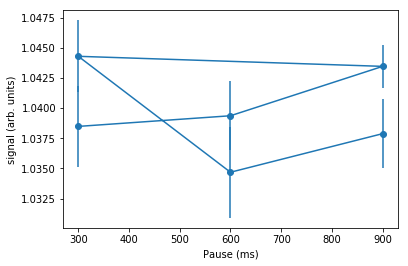

In [11]:
# plot
fig, ax = plt.subplots()

xvals = df[('var', 'PAUSE')]
yvals = df[('vrange', 'mean')]
yerr =  df[('vrange', 'err')]
ax.errorbar(xvals, yvals, yerr=yerr, marker='o')

#format
ax.set_xlabel('Pause (ms)')
ax.set_ylabel('signal (arb. units)')

#output
plt.show()

## Statistics over loops

It's not unusual to repeat a measurement using a certain configuration of experiment settings.

The plot above indicates that there were 2 loops recorded that each contained repeat measurements with the same VAR conditions.  These can be grouped together to find the statistics for unique VAR values.

In [12]:
# map measurements to var values
df2 = h5.var.join(vr)
df2.head()

PAUSE    vrange
squid repeat                 
1     0         300  1.033028
      1         300  1.012191
      2         300  1.032403
      3         300  1.070328
      4         300  1.062143

In [13]:
# then evaluate the statistics when grouped by var values
st = statistics(df2, groupby=h5.var.columns, mode='full')
st.head()

vrange                                                              \
       count       err       max      mean    median       min     range   
PAUSE                                                                      
300       50  0.002260  1.083854  1.041386  1.040635  1.000539  0.083316   
600       50  0.002367  1.064080  1.037024  1.042134  0.997321  0.066759   
900       51  0.001702  1.069203  1.040724  1.041619  1.012878  0.056325   

                 
            std  
PAUSE            
300    0.015981  
600    0.016739  
900    0.012155

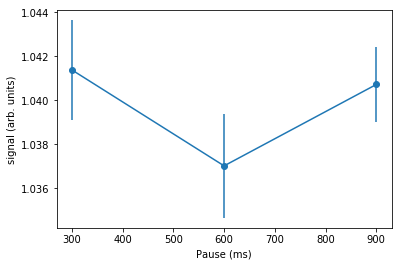

In [14]:
# plot
fig, ax = plt.subplots()

xvals = st.index.get_level_values('PAUSE')
yvals = st[('vrange', 'mean')]
yerr =  st[('vrange', 'err')]
ax.errorbar(xvals, yvals, yerr=yerr, marker='o')

#format
ax.set_xlabel('Pause (ms)')
ax.set_ylabel('signal (arb. units)')

#output
plt.show()